# Overall idea
Given a puppet and a face, make the puppet to mimic the face if the face changes.

Approach:

1) Find the face landmarks for the puppet and the face.
2) A function that takes the puppet, landmarks, and landmarks delta and generate the puppet with the new landmarks
    2-a) triangulate the original landmarks
    2-b) apply the same triangulation to the new landmarks
    2-c) find tranformation from the triangles in the original landmarks to the corresponding triangles in the new landmarks
    2-d) apply that transformation to the puppet itself to warp the patterns accordingly
    



In [2]:
from utils.face_geometry import FaceGeometry
import cv2

images_path = 'images/'
images_path

'images/'

In [200]:
from matplotlib import pyplot as plt

import numpy as np

def __cropp_triangle(img, landmarks_points, triangle_index):
    # Get triangle vertices. Note, this is in an abstract space, with no pattern.
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)
    
    # Build a rectangle to bound the triangle. Just coordinates, no patterns.
    triangle_bounding_rect = cv2.boundingRect(triangle)
    (x, y, w, h) = triangle_bounding_rect
    
    # Crrop that rectangle from the original image, now it has the image pattern in the rectangle.
    # Note that the rectangle is a small part of the image, and its coordinates start from 0 and 0. It 
    # has been crropped from the image and forms a new little image.
    triangle_pattern_box = img[y: y + h, x: x + w]
    cropped_tr_mask = np.zeros((h, w), np.uint8)
    
    # Now we need to recreate the triangle in the rectangle with the patter, and get rid of patterns outside of the 
    # triangle.    
    # First, offset points by left top corner of the respective rectangles
    triangle_vertices = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
    
    # Now, mask things out of the triangle.
    cv2.fillConvexPoly(cropped_tr_mask, triangle_vertices, 255)
    
    res = {'triangle_pattern': triangle_pattern_box, 
           'triangle_vertices': triangle_vertices, 
           'triangle_bounding_rect': triangle_bounding_rect, 
           'triangle_mask': cropped_tr_mask}
    
    return res

def apply_landmarks(image, face_rect, original_landmarks_points, triangles_index, modified_landmarks_points):
    '''
    Given an image, the face bounding box (face_rect), landmarks (original_landmarks), and delauney triangles of the 
    landmarks (triangles_index), modify the face in a way that it follows the provided modified_landmarks
    
    ''' 
    final_mrphed = np.zeros(image.shape, dtype = image.dtype)

    # def apply_landmark_purturb(img, triangles_indexes, original_landmarks, modified_landmarks):
    for triangle_indx in triangles_index:
        # Get triangle points of the orig
        triangle_org = __cropp_triangle(image, original_landmarks_points, triangle_indx)

        # Get triangle points of the modified
        triangle_mdf = __cropp_triangle(image, modified_landmarks_points, triangle_indx)
        
        # Get the transformation from orig to mod using triangle points
        points_org = np.float32(triangle_org['triangle_vertices'])
        points_mdf = np.float32(triangle_mdf['triangle_vertices'])

        M = cv2.getAffineTransform(points_org, points_mdf)
        # Filter out if M is eye

        (x, y, w, h) = triangle_mdf['triangle_bounding_rect']

        # Apply the mapping to the triangle in d with patterns 
        warped_triangle = cv2.warpAffine(triangle_org['triangle_pattern'], M, (w, h))        

        # Now remove patterns outside of the triangle after warping
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=triangle_mdf['triangle_mask'])

        img2_new_face_rect_area = final_mrphed[y: y + h, x: x + w]
        img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
        _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

        img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
        final_mrphed[y: y + h, x: x + w] = img2_new_face_rect_area
    
    # Stitch the face back to the original.
    mask = np.zeros(image.shape, dtype = image.dtype)  
    cnvxhl = cv2.convexHull(np.array(original_landmarks_points))
    cv2.fillConvexPoly(mask, np.int32(cnvxhl), (255, 255, 255))
    r = face_rect
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    output = cv2.seamlessClone(np.uint8(final_mrphed), image, mask, center, cv2.NORMAL_CLONE)
    
    return final_mrphed

In [3]:
perc_out_face=0.5
puppet_image_file = 'wilk.png'
# puppet_image_file = 'two.jpg'

puppet_img = cv2.imread(''.join([images_path, puppet_image_file]))
landmarks_file = ''.join([images_path, 'wilk_face_open_mouth.txt'])
# landmarks_file = 'align'

puppet_geometry = FaceGeometry(puppet_img, landmarks_model=landmarks_file, 
                                perc_out_face=perc_out_face).build_geometry()

In [4]:
puppet_geometry.visualize(overlay_on_image=True)

In [5]:
modified_landmarks = np.asarray(puppet_landmarks_points_corners)
modified_landmarks[10][0] += 20
modified_landmarks[10][1] += 20
modified_landmarks_points = [(int(lnd[0]), int(lnd[1])) for lnd in modified_landmarks] 

show_image(puppet_img, modified_landmarks_points, None, False)

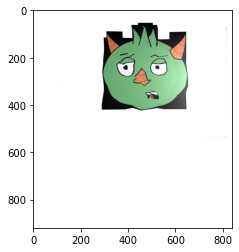

In [12]:
modified_landmarks = np.asarray(puppet_geometry.face_landmarks_points_with_corners)
# modified_landmarks[10][0] += 20
# modified_landmarks[10][1] += 20
rnd = (np.random.rand(modified_landmarks.shape[0], modified_landmarks.shape[1])-0.5)*20
modified_landmarks = modified_landmarks+np.array(rnd, dtype=np.int32)
modified_landmarks_points = [(int(lnd[0]), int(lnd[1])) for lnd in modified_landmarks] 

mrp_img = apply_landmarks(puppet_geometry.image, puppet_geometry.face_rect, 
                          puppet_geometry.face_landmarks_points_with_corners, 
                          puppet_geometry.face_triangles_index, modified_landmarks_points)

plt.imshow(cv2.cvtColor(mrp_img, cv2.COLOR_BGR2RGB))


In [16]:
perc_out_face=0.5
face_image_file = 'kang0.jpg'
# puppet_image_file = 'two.jpg'

face_img = cv2.imread(''.join(['images/reza/', face_image_file]))
# landmarks_file = ''.join([images_path, 'wilk_face_open_mouth.txt'])
landmarks_file = 'dlib'

face_1_geometry = FaceGeometry(face_img, landmarks_model=landmarks_file, 
                                perc_out_face=perc_out_face).build_geometry()

In [20]:
perc_out_face=0.5
face_image_file = 'kang95.jpg'
# puppet_image_file = 'two.jpg'

face_img = cv2.imread(''.join(['images/reza/', face_image_file]))
# landmarks_file = ''.join([images_path, 'wilk_face_open_mouth.txt'])
landmarks_file = 'dlib'

face_2_geometry = FaceGeometry(face_img, landmarks_model=landmarks_file, 
                                perc_out_face=perc_out_face).build_geometry()

In [196]:
def get_triangle(landmarks_points, triangle_index):
    # Get triangle vertices. Note, this is in an abstract space, with no pattern.
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)
    
    # Build a rectangle to bound the triangle. Just coordinates, no patterns.
    triangle_bounding_rect = cv2.boundingRect(triangle)
    (x, y, w, h) = triangle_bounding_rect
    
    # Now we need to recreate the triangle in the rectangle with the patter, and get rid of patterns outside of the 
    # triangle.    
    # First, offset points by left top corner of the respective rectangles
    triangle_vertices = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
    return triangle_vertices, x, y
    
# Make triangles corresponding
face_1_geometry.face_triangles_index = puppet_geometry.face_triangles_index
face_2_geometry.face_triangles_index = puppet_geometry.face_triangles_index

triangles_index = puppet_geometry.face_triangles_index

face_2_geometry.face_landmarks_points_with_corners

transformed_points = np.empty((len(face_2_geometry.face_landmarks_points_with_corners),2))

for triangle_indx in triangles_index:
    # Get triangle points of the orig
    tp, xp, yp = get_triangle(puppet_geometry.face_landmarks_points_with_corners, triangle_indx)
    # Get triangle points of the modified
    tf1, xf1, yf1 = get_triangle(face_1_geometry.face_landmarks_points_with_corners, triangle_indx)
    tf2, xf2, yf2 = get_triangle(face_2_geometry.face_landmarks_points_with_corners, triangle_indx)
    
    # Get the transformation from orig to mod using triangle points
    points_p = np.float32(tp)
    points_f1 = np.float32(tf1)
    points_f2 = np.float32(tf2)

    M_f1_p = cv2.getAffineTransform(points_f1, points_p)    
    M_p_f1 = cv2.getAffineTransform(points_p, points_f1)
    M_f1_f2 = cv2.getAffineTransform(points_f1, points_f2)
    
    f2_extend = np.concatenate([points_f2, np.ones((3, 1))], axis=1)
    new_points = np.dot(M_f1_p, f2_extend.T).T
    new_points += [xp, yp]
    
    transformed_points[triangle_indx[0], :] = new_points[0,:]
    transformed_points[triangle_indx[1], :] = new_points[1,:]
    transformed_points[triangle_indx[2], :] = new_points[2,:]
    print(triangle_indx)
    print(points_p)
    print(points_f1)
    print(points_f2)
    print(new_points)

[37, 21, 27]
[[ 0. 21.]
 [ 4.  0.]
 [37. 50.]]
[[  0.  34.]
 [ 82.   0.]
 [112.  49.]]
[[  0.  42.]
 [ 79.   0.]
 [114.  62.]]
[[424.10639143 216.51091703]
 [423.21516475 187.60043668]
 [464.19610957 250.47161572]]
[21, 37, 20]
[[15.  1.]
 [11. 22.]
 [ 0.  0.]]
[[82. 20.]
 [ 0. 54.]
 [40.  0.]]
[[79. 25.]
 [ 0. 67.]
 [39.  0.]]
[[425.15384615 189.94850065]
 [424.5        213.08474576]
 [408.80769231 187.12581486]]
[36, 0, 17]
[[45. 24.]
 [ 0.  2.]
 [46.  0.]]
[[63. 26.]
 [ 0. 31.]
 [19.  0.]]
[[66. 36.]
 [ 0. 37.]
 [22.  0.]]
[[358.8853606  215.0452099 ]
 [316.40258342 190.75672766]
 [370.8810549  188.11733046]]
[0, 36, 41]
[[ 0.  0.]
 [45. 22.]
 [33. 48.]]
[[ 0.  5.]
 [63.  0.]
 [84. 13.]]
[[ 0.  1.]
 [66.  0.]
 [88. 19.]]
[[330.36363636 183.90909091]
 [369.70454545 212.35064935]
 [347.22727273 246.43722944]]
[0, 72, 17]
[[  0. 120.]
 [149.   0.]
 [ 46. 118.]]
[[  0. 305.]
 [241.   0.]
 [ 19. 274.]]
[[  0. 323.]
 [252.   0.]
 [ 22. 286.]]
[[234.3424821  169.68973747]
 [410.23329356  4

In [197]:
rnd = np.int32(np.round(transformed_points))
rnd[:,0] -= np.min(rnd[:,0])
rnd[:,1] -= np.min(rnd[:,1])
rnd

img = puppet_img.imag
img_copy = np.zeros((img.shape))

for p in rnd:
    cv2.circle(img_copy, (p[0], p[1]), 3, (0, 255, 0), -1)
cv2.imshow('img1', img_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [198]:
puppet_geometry.visualize(overlay_on_image=False)

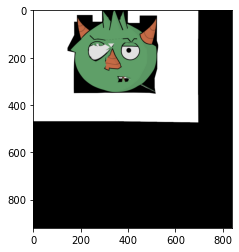

In [201]:
mrp_img = apply_landmarks(puppet_geometry.image, puppet_geometry.face_rect, 
                          puppet_geometry.face_landmarks_points_with_corners, 
                          puppet_geometry.face_triangles_index, rnd)

plt.imshow(cv2.cvtColor(mrp_img, cv2.COLOR_BGR2RGB))

In [111]:
points_p

array([[ 0., 21.],
       [ 4.,  0.],
       [37., 50.]], dtype=float32)

In [141]:
points_f1

array([[  0.,  34.],
       [ 82.,   0.],
       [112.,  49.]], dtype=float32)

In [136]:
f1_extend = np.concatenate([points_f1, np.ones((3, 1))], axis=1)
f1_extend

array([[  0.,  34.,   1.],
       [ 82.,   0.,   1.],
       [112.,  49.,   1.]])

In [148]:
np.dot(M_f1_p, f1_extend.T).T

array([[3.55271368e-15, 2.10000000e+01],
       [4.00000000e+00, 3.55271368e-15],
       [3.70000000e+01, 5.00000000e+01]])

In [147]:
cv2.transform(M_f1_p, f1_extend)

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6sxsq0tp\opencv\modules\core\src\matmul.dispatch.cpp:439: error: (-215:Assertion failed) scn == m.cols || scn + 1 == m.cols in function 'cv::transform'


In [80]:
face_1_geometry.visualize(overlay_on_image=False)

In [15]:
# Make triangles corresponding
face_1_geometry.face_triangles_index = puppet_geometry.face_triangles_index
face_2_geometry.face_triangles_index = puppet_geometry.face_triangles_index

In [70]:
triangles_index = puppet_geometry.face_triangles_index
final_mrphed = np.zeros(puppet_geometry.image.shape, dtype = puppet_geometry.image.dtype)

for triangle_indx in triangles_index:
    # Get triangle points of the orig
    triangle_p = __cropp_triangle(puppet_geometry.image, puppet_geometry.face_landmarks_points_with_corners, triangle_indx)

    # Get triangle points of the modified
    triangle_f1 = __cropp_triangle(face_1_geometry.image, face_1_geometry.face_landmarks_points_with_corners, triangle_indx)
    
    # Get triangle points of the modified
    triangle_f2 = __cropp_triangle(face_2_geometry.image, face_2_geometry.face_landmarks_points_with_corners, triangle_indx)

    # Get the transformation from orig to mod using triangle points
    points_p = np.float32(triangle_p['triangle_vertices'])
    points_f1 = np.float32(triangle_f1['triangle_vertices'])
    points_f2 = np.float32(triangle_f2['triangle_vertices'])

    M_f1_p = cv2.getAffineTransform(points_f1, points_p)    
    M_p_f1 = cv2.getAffineTransform(points_p, points_f1)
    M_f1_f2 = cv2.getAffineTransform(points_f1, points_f2)
    
    (xp, yp, wp, hp) = triangle_p['triangle_bounding_rect']
    (x1, y1, w1, h1) = triangle_f1['triangle_bounding_rect']
    (x2, y2, w2, h2) = triangle_f2['triangle_bounding_rect']
    

    # Apply the mapping to the triangle in d with patterns 
    warped_triangle = cv2.warpAffine(triangle_p['triangle_pattern'], M_p_f1, (w1, h1))
    warped_triangle = cv2.warpAffine(warped_triangle, M_f1_f2, (w1, h1))
    warped_triangle = cv2.warpAffine(warped_triangle, M_f1_p, (wp, hp))
#     print(points_f2-points_f1)
    # Now remove patterns outside of the triangle after warping
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=triangle_p['triangle_mask'])
    
    img2_new_face_rect_area = final_mrphed[yp: yp + hp, xp: xp + wp]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    final_mrphed[yp: yp + hp, xp: xp + wp] = img2_new_face_rect_area

In [71]:
# plt.imshow(cv2.cvtColor(final_mrphed, cv2.COLOR_BGR2RGB))
cv2.imshow('img1', final_mrphed)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [29]:
final_mrphed = np.zeros(image.shape, dtype = image.dtype)

# def apply_landmark_purturb(img, triangles_indexes, original_landmarks, modified_landmarks):
for triangle_indx in triangles_index:
    # Get triangle points of the orig
    triangle_org = __cropp_triangle(image, original_landmarks_points, triangle_indx)

    # Get triangle points of the modified
    triangle_mdf = __cropp_triangle(image, modified_landmarks_points, triangle_indx)

    # Get the transformation from orig to mod using triangle points
    points_org = np.float32(triangle_org['triangle_vertices'])
    points_mdf = np.float32(triangle_mdf['triangle_vertices'])

    M = cv2.getAffineTransform(points_org, points_mdf)
    # Filter out if M is eye

    (x, y, w, h) = triangle_mdf['triangle_bounding_rect']

    # Apply the mapping to the triangle in d with patterns 
    warped_triangle = cv2.warpAffine(triangle_org['triangle_pattern'], M, (w, h))        

    # Now remove patterns outside of the triangle after warping
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=triangle_mdf['triangle_mask'])

    img2_new_face_rect_area = final_mrphed[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    final_mrphed[y: y + h, x: x + w] = img2_new_face_rect_area

array([[ 1.10236654, -0.03797468,  0.        ],
       [ 0.14034122,  1.18987342,  0.        ]])

In [28]:
M_f1_p[0]

array([[  0.26161175,   0.51329893, -17.45216356],
       [  0.13318777,   0.93886463, -10.92139738]])

In [15]:
M = cv2.getAffineTransform(np.float32(puppet_geometry.face_landmarks_points[0:3]), 
                           np.float32(face_geometry.face_landmarks_points[0:3]))

In [16]:
M

array([[ 3.84848485e-01,  1.78787879e-01, -7.60969697e+01],
       [-5.45454545e-01,  1.63636364e+00,  3.40909091e+02]])

In [14]:
face_geometry.face_landmarks_points[0:2]

[(82, 474), (81, 534)]

In [16]:
import cv2

# Opens the Video file
cap= cv2.VideoCapture('E:/Projects/Git_folder/pinocchio/images/reza.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    img = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    scale_percent = 60 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    cv2.imwrite('images/reza/kang'+str(i)+'.jpg',resized)
    i+=1
    
cap.release()
cv2.destroyAllWindows()

In [39]:
def show_image(img, landmark_points, triangles, overlay_on_image=True):
    if overlay_on_image:
        img_copy = img.copy()
    else:
        img_copy = np.zeros((img.shape))

    for p in landmark_points:
        cv2.circle(img_copy, p, 3, (0, 255, 0), -1)
    
    if triangles is not None:
        delaunay_color = (0, 0, 0)

        for t in triangles:
            pt1 = landmark_points[t[0]]
            pt2 = landmark_points[t[1]]
            pt3 = landmark_points[t[2]]
            cv2.line(img_copy, pt1, pt2, delaunay_color, 1)
            cv2.line(img_copy, pt2, pt3, delaunay_color, 1)
            cv2.line(img_copy, pt3, pt1, delaunay_color, 1)

    cv2.imshow('img1', img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
show_image(puppet_img, puppet_landmarks_points_corners, puppet_triangles_index)
# show_image(face_img, face_landmarks_points_corners, face_triangles_index)

NameError: name 'puppet_landmarks_points_corners' is not defined

In [65]:
show_image(mrp_img, modified_landmarks_points, None, True)

In [12]:
cv2.imshow("Image 1", output)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
image_name = 'wilk.png'
puppet = cv2.imread(''.join([images_path, image_name]))

# Read landmarks
landmarks_file = 'wilk_face_open_mouth.txt'
f = open(''.join([images_path, landmarks_file]), "r")
Lines = f.readlines() 
  
count = 0
landmarks = []
for line in Lines: 
    x, y, _ = line.split(' ')
    landmarks.append([int(float(x)), int(float(y))])
f.close()

triangles_p, rects_p, landmark_points_p, face_p = get_geometry(puppet, landmarks)


In [14]:
show_images(puppet, triangles_p, landmark_points_p, rects_p)

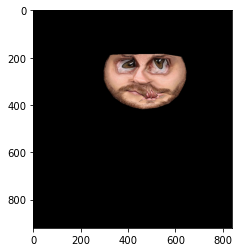

In [16]:
mrp = transform_triangles(puppet, img_2, landmark_points_p, landmark_points2, triangles_p)
plt.imshow(cv2.cvtColor(mrp, cv2.COLOR_BGR2RGB))
